# Forecast Hybrid Production Notebook
Author: George Panagiotou

In [2]:
import pandas as pd
import numpy as np
from comp_utils import *
import xgboost as xgb
import os
from sklearn.metrics import make_scorer
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

## Test and train data:

In [3]:
Wind_train = pd.read_csv('data/ExtremeGB/Wind_quantiles_train_set.csv')
Wind_train = Wind_train.rename(columns={'q10': 'qw10','q20': 'qw20','q30': 'qw30','q40': 'qw40','q50': 'qw50','q60': 'qw60','q70': 'qw70','q80': 'qw80','q90': 'qw90' }) 

Solar_train = pd.read_csv('data/ExtremeGB/Solar_quantiles_train_set.csv')
Solar_train = Solar_train.rename(columns={'q10': 'qs10','q20': 'qs20','q30': 'qs30','q40': 'qs40','q50': 'qs50','q60': 'qs60','q70': 'qs70','q80': 'qs80','q90': 'qs90' }) 

Train_set = Solar_train.merge(Wind_train, on='time')

train_target_variable = Train_set['Wind_MWh_credit']+Train_set['Solar_MWh_credit']
Train_set = Train_set.rename(columns={'time':'valid_time'})
Train_set['valid_time'] = pd.to_datetime(Train_set['valid_time'])
train_times = Train_set['valid_time']
Train_set = add_cyclic_features(Train_set)
Train_set = Train_set.drop(columns=['Wind_MWh_credit','Solar_MWh_credit','valid_time'])
print('Train features after removing columns:', Train_set.shape)

Wind_test = pd.read_csv('data/ExtremeGB/Wind_quantiles_test_set.csv')
Wind_test = Wind_test.rename(columns={'q10': 'qw10','q20': 'qw20','q30': 'qw30','q40': 'qw40','q50': 'qw50','q60': 'qw60','q70': 'qw70','q80': 'qw80','q90': 'qw90' }) 

Solar_test = pd.read_csv('data/ExtremeGB/Solar_quantiles_test_set.csv')
Solar_test = Solar_test.rename(columns={'q10': 'qs10','q20': 'qs20','q30': 'qs30','q40': 'qs40','q50': 'qs50','q60': 'qs60','q70': 'qs70','q80': 'qs80','q90': 'qs90' }) 

Test_set = Solar_test.merge(Wind_test, on='time')
test_target_variable = Test_set['Wind_MWh_credit']+Test_set['Solar_MWh_credit']
Test_set = Test_set.rename(columns={'time':'valid_time'})
Test_set['valid_time'] = pd.to_datetime(Test_set['valid_time'])
test_times = Test_set['valid_time']
Test_set = add_cyclic_features(Test_set)
Test_set = Test_set.drop(columns=['Wind_MWh_credit','Solar_MWh_credit','valid_time'])
print('Test features after removing columns:', Test_set.shape)

Train features after removing columns: (56284, 27)
Test features after removing columns: (4318, 27)


## XGBR (Tuning)
!!! DO NOT RUN !!!

In [10]:
search_spaces = {
    'learning_rate': Real(0.05, 0.2, 'uniform'),
    'max_depth': Integer(1, 14), 
    'n_estimators': Integer(100, 400), 
}

quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
best_models = {}

# Function to compute pinball loss
def pinball_loss(y_true, y_pred, alpha):
    residuals = y_true - y_pred
    return np.mean(np.maximum(alpha * residuals, (alpha - 1) * residuals))

# Lists to store errors for plotting
cv_errors = []
train_errors = []
quantile_labels = []

# Perform Bayesian optimization search for each quantile
for quantile in quantiles:
    print(f"Running Bayesian optimization search for the {quantile * 100}% quantile.")
    model = xgb.XGBRegressor(
        objective='reg:quantileerror',
        quantile_alpha=quantile,
        tree_method='hist',
        verbosity=0
    )

    custom_scorer = make_scorer(pinball_loss, greater_is_better=False, alpha=quantile)
    optimizer = BayesSearchCV(
        estimator=model,
        search_spaces=search_spaces,
        n_iter=16,  
        cv=5,  
        scoring=custom_scorer,
        verbose=1,
        n_jobs=-1,
        return_train_score=True
    )
    optimizer.fit(Train_set, train_target_variable)
    best_model = optimizer.best_estimator_


    model_path = f'models/ExtremeGB/W&S_XGBR_BEST_q{int(quantile * 100)}.json'
    best_model.save_model(model_path) 

    print(f"Best parameters for {quantile * 100}% quantile: {optimizer.best_params_}")
    best_models[f'q{int(quantile*100)}'] = best_model

    # Retrieve and store CV and training errors for the optimal model
    mean_test_score = optimizer.cv_results_['mean_test_score'][optimizer.best_index_]
    mean_train_score = optimizer.cv_results_['mean_train_score'][optimizer.best_index_]
    cv_errors.append(mean_test_score)
    train_errors.append(mean_train_score)
    quantile_labels.append(f'q{int(quantile * 100)}')

    print(f"CV error for {quantile * 100}% quantile: {mean_test_score}")
    print(f"Training error for {quantile * 100}% quantile: {mean_train_score}")

print("Optimization complete. Best models saved.")

Running Bayesian optimization search for the 10.0% quantile.
Fitting 5 folds for each of 1 candidates, totalling 5 fits


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for 10.0% quantile: OrderedDict([('learning_rate', 0.19902897471406006), ('max_depth', 4), ('n_esti

## Test set

In [4]:
quantile_predictions = {}
quantile_predictions['total_generation_MWh'] = test_target_variable

quantiles = range(10, 100, 10)

# Create a DMatrix from your dataframe if train_table is a DataFrame
dtest = xgb.DMatrix(Test_set)

for qu in quantiles:
    model_path = f'models/ExtremeGB/W&S_XGBR_BEST_q{qu}.json'
    model = xgb.Booster(model_file=model_path)
    quantile_predictions[f'q{qu}'] = model.predict(dtest)

quantile_predictions_df = pd.DataFrame(quantile_predictions)

# Process the predictions to ensure non-negative values
quantile_columns = [col for col in quantile_predictions_df.columns if col.startswith('q')]
quantile_predictions_df[quantile_columns] = quantile_predictions_df[quantile_columns].map(lambda x: max(x, 0))
quantile_predictions_df = sort_quantiles(quantile_predictions_df, quantile_columns)


# Assuming the function pinball_score exists and is correctly implemented
print('Test Loss(Quantile):',pinball_score(quantile_predictions_df, target_col='total_generation_MWh'))

Test Loss(Quantile): 22.75805637410426


## Plot Quantiles ( Probabilistic Forecasting) : 

In [8]:
save_path = "plots/ExtremeGB/W&S_XGBR_Plot.html"
graph_title = "Hybrid Production Forecast (XGBR-2)"
quantile_predictions_df['time'] = test_times  
plot_quantiles_target_and_average_loss_interactive(quantile_predictions_df, 'total_generation_MWh', test_times, save_path, title=graph_title)

## Plot Statistics of Quantiles

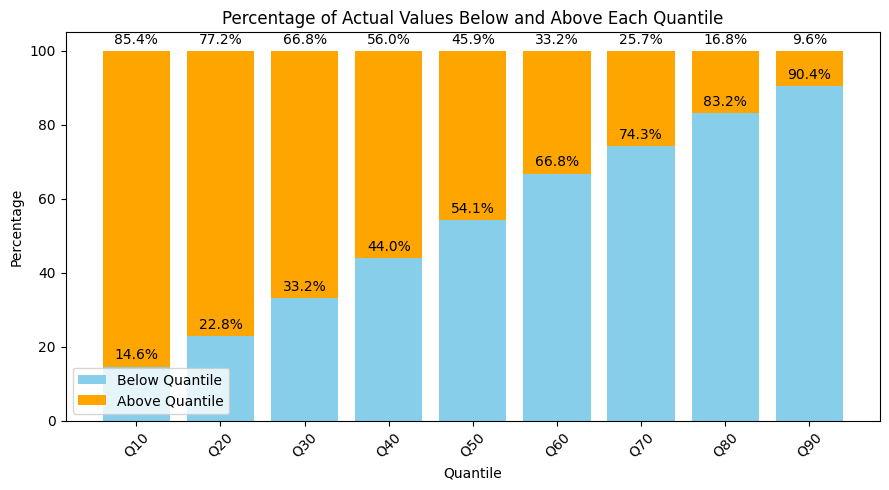

In [6]:
quantile_stats(quantile_predictions_df)

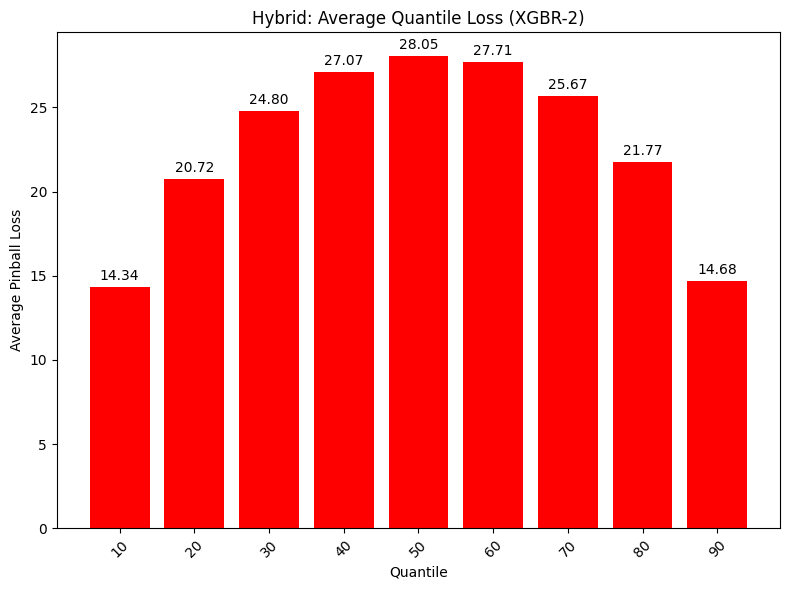

In [7]:
calculate_and_plot_average_quantile_loss(quantile_predictions_df, 'total_generation_MWh', "Hybrid: Average Quantile Loss (XGBR-2)")